In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import statsmodels.api as sm
import itertools

In [127]:
def drop_columns(thresh, data):
    for var in data:
        if data[var].isna().sum() > thresh:
            data = data.drop(var, axis=1)
            
    return data

In [128]:
def load_peace_sys_data():
    df = pd.DataFrame(pd.read_csv('revised_peace_sys.csv', index_col=0, na_values=['(NA)']))
    return df

In [129]:
def get_odds_ratios(coefs):
    return np.exp(coefs[0])


In [130]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    # first index refers to proba that belongs to class 0
    # second index refers to proba that belongs to calss 1
    p = model.predict_proba(x) # return matrix (N,2)
    # number of samples
    n = len(p)
    # number of features + 1 
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]]) # put intercept and coefs in same array
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1)) # 
    ans = np.zeros((m, m))
    for i in range(n):
        # dot product of transposed row and row
        # then multiply by both probas
        # add it to ans
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    # acovariance matrix
    vcov = np.linalg.inv(np.matrix(ans))
    # square root diagonal of covariace matrix
    se = np.sqrt(np.diag(vcov))
    # divide coefs by standard error
    t =  coefs/se 
    # two tailed using normal dist
    p = (1 - stats.norm.cdf(abs(t))) * 2
    return p

In [131]:
def logit_with_nan(data):
    data_copy = data.drop('PSys', axis=1)
    pvalues = []
    logit_beta = []
    logit_odds_ratio = []

    
    for label in data_copy.columns:
        X = data[[label, 'PSys']]
        X = X.dropna()
        
        y = X.PSys
        X = X.drop('PSys', axis=1)
        logreg = LogisticRegression(random_state=42, C=1e9)
        logreg.fit(X, y)
        pvalue = logit_pvalue(logreg, X)[1]
        
        pvalues.append(pvalue)
        
#         beta = np.absolute(logreg.coef_[0][0])
        beta = logreg.coef_[0][0]
        logit_beta.append(beta)
        logit_odds_ratio.append(np.exp(beta))
        
        
    res = pd.DataFrame({'Variable' : data_copy.columns,
                        'Logistic_Sig_Level' : pvalues,
                        'Logistic_Beta' : logit_beta,
                        'Logistic_Odds_Ratio' : logit_odds_ratio
                       })
    
    res = res.set_index('Variable')
    
    return res

In [132]:
def compute_ttest(peaceful, non_peaceful):
    variables = peaceful.columns
    res_df = pd.DataFrame(columns=['feature', 't_statistic', 'p_value'])
    
    for var in variables:
        x = peaceful[var]
        y = non_peaceful[var]
        ttest = stats.ttest_ind(x, y)
        temp = pd.DataFrame({'feature' : [var] , 
                             't_statistic' : ttest.statistic, 
                             'p_value' : [ttest.pvalue]})
        res_df = res_df.append(temp)
        
    res_df.set_index('feature', inplace=True)
    return res_df

In [133]:
def ttest_with_nan(data):
    """ 
    This is a two sided test for the null hypothesis that 2 independent samples
    have identical average(expected) values.
    
    Test assusmes that the populations have identical variances by default
    
    Parameters
    ----------
    data: DataFrame
        The DataFrame that contains Nan values
        
    Returns
    -------
    returns DataFrame that contains statistic and pvalue for every column in data
    
    t_statistic: float
        Calculated t-statistic
    
    p_value: float
        Two tailed p-value
            
    """
    # create a copy that excludes target variable
    data_copy = data.drop('PSys', axis=1)
    # prepare result data frame
    res_df = pd.DataFrame(columns=['Variable', 't_statistic', 'ttest_p_value'])
    # for every label, we separate each row by what its target value is
    # we drop the nan values
    for label in data_copy.columns:
        X = data[[label, 'PSys']]
        X = X.dropna()
        # filter peaceful 
        peaceful = X[X.PSys == 1]
        peaceful = peaceful.drop('PSys', axis=1)
        
        non_peaceful = X[X.PSys == 0]
        non_peaceful = non_peaceful.drop('PSys', axis=1) 
        # calculate two-sided ttest
        ttest_result = stats.ttest_ind(peaceful, non_peaceful)
        ttest_df = pd.DataFrame({'Variable' : [label],
                                 't_statistic' : ttest_result.statistic,
                                 'ttest_p_value' : ttest_result.pvalue
                                })
        
        res_df = res_df.append(ttest_df)
    
    res_df.set_index('Variable', inplace=True)
    
    return res_df

In [134]:
def compute_mannwhitneyu(peaceful, non_peaceful):
    variables = peaceful.columns
    res_df = pd.DataFrame(columns=['feature', 'statistic', 'p_value'])
    
    for var in variables:
        x = peaceful[var]
        y = non_peaceful[var]
        utest = stats.mannwhitneyu(x, y)
        temp = pd.DataFrame({'feature' : [var] , 
                             'statistic' : utest.statistic, 
                             'p_value' : [utest.pvalue]})
        res_df = res_df.append(temp)
        
    res_df.set_index('feature', inplace=True)
    return res_df

In [135]:
def mannwhitneyu_with_nan(data):
    """ 
    Computes the Mann-Whitney rank test on each of the columns of data
    Each column is seperated into 2 different arrays
    
    One group is peaceful, the other group is non-peaceful
    
    Parameters
    ----------
    data : DataFrame
        DataFrame that contains nan values
        
    Returns:
    -------
    Retures a DataFrame with U_statistic and Pvalue for every column
    
    U_statististic: float
        Mann-Whitney U statistic, equal to min(U for x, and U for y)
        
    p_value: float
        p-value assuming asymptotic normal distribution. Two-Sided.
    """
    data_copy = data.drop('PSys', axis=1)
    res_df = pd.DataFrame(columns=['Variable', 'U_statistic', 'mannwhitneyu_p_value'])
    for label in data_copy.columns:
        # isolate the target variable and current variable
        X = data[[label, 'PSys']]
        # drop all Nan values
        X = X.dropna()
        # filter out peaceful rows
        peaceful = X[X.PSys == 1]
        peaceful = peaceful.drop('PSys', axis=1)
        # filter out non peaceful rows
        non_peaceful = X[X.PSys == 0]
        non_peaceful = non_peaceful.drop('PSys', axis=1) 
        # calculates two-sided Mann-Whitney U test
        utest_result = stats.mannwhitneyu(peaceful, non_peaceful, alternative='two-sided')
        ttest_df = pd.DataFrame({'Variable' : [label],
                                 'U_statistic' : utest_result.statistic,
                                 'mannwhitneyu_p_value' : utest_result.pvalue
                                })
        
        res_df = res_df.append(ttest_df)
    
    res_df.set_index('Variable', inplace=True)
    
    return res_df

In [136]:
peace_sys = load_peace_sys_data()

peace_sys

,SCCS,Coder,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,...,COMcm,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,107,KA,9.0,2.0,3,9.0,9,9,9,9,...,9.0,9.00,9.000000,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,108,EC,1.0,9.0,9,1.0,9,9,9,9,...,9.0,9.00,9.000000,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,135,"KA, EC",9.0,9.0,9,9.0,9,9,1,1,...,9.0,2.50,9.000000,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,154,KA,9.0,3.0,9,3.0,9,9,9,3,...,9.0,9.00,9.000000,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,35,KA,9.0,2.0,3,4.0,9,4,9,2,...,9.0,3.50,9.000000,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,157,DG,9.0,2.0,2,9.0,9,9,9,9,...,9.0,3.00,9.000000,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,23,DG,1.0,2.0,4,9.0,1,3,3,9,...,9.0,9.00,9.000000,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,54,DG,4.0,9.0,1,9.0,9,9,9,9,...,9.0,9.00,9.000000,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,109,DG,3.0,9.0,4,4.0,3,9,3,9,...,9.0,9.00,9.000000,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [137]:
peace_sys = peace_sys.drop(['SCCS','Coder', 'PSysRec'], axis=1)

In [138]:
peace_sys

,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,Dep3.3Econ,NWVal4.1,...,COMcm,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,9.0,2.0,3,9.0,9,9,9,9,9.0,9.0,...,9.0,9.00,9.000000,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,1.0,9.0,9,1.0,9,9,9,9,3.0,4.0,...,9.0,9.00,9.000000,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,9.0,9.0,9,9.0,9,9,1,1,1.0,2.5,...,9.0,2.50,9.000000,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,9.0,3.0,9,3.0,9,9,9,3,3.0,3.0,...,9.0,9.00,9.000000,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,9.0,2.0,3,4.0,9,4,9,2,3.0,3.0,...,9.0,3.50,9.000000,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,9.0,2.0,2,9.0,9,9,9,9,9.0,2.0,...,9.0,3.00,9.000000,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,1.0,2.0,4,9.0,1,3,3,9,2.0,4.0,...,9.0,9.00,9.000000,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,4.0,9.0,1,9.0,9,9,9,9,9.0,9.0,...,9.0,9.00,9.000000,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,3.0,9.0,4,4.0,3,9,3,9,3.0,3.0,...,9.0,9.00,9.000000,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [139]:
peace_sys = peace_sys.replace(9, np.nan)

In [140]:
peace_sys

,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,Dep3.3Econ,NWVal4.1,...,COMcm,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.5,...,NaN,2.50,NaN,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,NaN,3.0,NaN,3.0,NaN,NaN,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,NaN,2.0,3.0,4.0,NaN,4.0,NaN,2.0,3.0,3.0,...,NaN,3.50,NaN,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,3.00,NaN,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,1.0,2.0,4.0,NaN,1.0,3.0,3.0,NaN,2.0,4.0,...,NaN,NaN,NaN,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,3.0,NaN,4.0,4.0,3.0,NaN,3.0,NaN,3.0,3.0,...,NaN,NaN,NaN,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [141]:
peace_sys = drop_columns(peace_sys.shape[0] - 4, peace_sys)

In [142]:
peace_sys.head(10)

,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,Dep3.3Econ,NWVal4.1,...,COMmrs,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.5,...,NaN,2.5,NaN,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,NaN,3.0,NaN,3.0,NaN,NaN,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,NaN,2.0,3.0,4.0,NaN,4.0,NaN,2.0,3.0,3.0,...,NaN,3.5,NaN,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,3.0,NaN,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,1.0,2.0,4.0,NaN,1.0,3.0,3.0,NaN,2.0,4.0,...,NaN,NaN,NaN,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,3.0,NaN,4.0,4.0,3.0,NaN,3.0,NaN,3.0,3.0,...,NaN,NaN,NaN,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [143]:
peace_sys['PSys'] = peace_sys['PSys'].replace(2, 0)

In [144]:
peace_sys

,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,Dep3.3Econ,NWVal4.1,...,COMmrs,COMwvn,COMwmrs,COMinterM,COMdepM,COMnvvnM,COMmrsM,COMcmM,COMwvnM,COMwmrsM
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.822181,2.563218,3.127604,2.670701,2.627707,2.607751,2.363068
Marshallese,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,2.183230,2.666667,3.541667,2.174603,2.459286,2.725806,2.254735
E. Pomo,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.5,...,NaN,2.50,NaN,2.679324,1.000000,2.791667,2.670701,2.430714,2.500000,2.906250
Popoluca,NaN,3.0,NaN,3.0,NaN,NaN,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,2.683230,2.833333,3.041667,2.670701,2.627707,2.607751,2.363068
Konso,NaN,2.0,3.0,4.0,NaN,4.0,NaN,2.0,3.0,3.0,...,NaN,3.50,NaN,3.347826,2.500000,3.041667,2.696342,2.627707,3.500000,2.588068
Bribri,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,3.00,NaN,2.572181,2.563218,2.000000,2.670701,2.627707,3.000000,2.072917
Tallensi,1.0,2.0,4.0,NaN,1.0,3.0,3.0,NaN,2.0,4.0,...,NaN,NaN,NaN,2.746094,2.500000,3.500000,2.829431,2.196992,2.225806,2.363068
Russians,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.322181,2.563218,3.127604,2.670701,2.371992,2.607751,2.363068
Trukese,3.0,NaN,4.0,4.0,3.0,NaN,3.0,NaN,3.0,3.0,...,NaN,NaN,NaN,3.478261,2.833333,3.000000,2.307692,3.016992,2.881944,2.363068


In [145]:
# VARS = ['NWNorm5.1_1', 'RitP6_1', 'Dep3.3Econ_1', 'NWVal4.1_1',
#         'Int2.4Hist_1', 'ID1.1Over_1', 'Lead9.1P_1', 'Int2.2Econ_1', 
#         'Dep3.2Ecol_1', 'CM8.5Peace_1', 'SymP6_1', 'Dep3.1Sec_1', 'SuperOrd7_1', 'PSys']
VARS = ["WNorm5.2", "Lead9.2War", "SymWar6", "RitWar6", "WVal4.2", 
        "SymP6", "NWNorm5.1", "RitP6", "Dep3.3Econ", "Int2.4Hist", 
        "ID1.1Over", "NWVal4.1", "Int2.2Econ", "Dep3.2Ecol", "CM8.5Peace", "PSys"
       ]

In [146]:
# Actual name of vars
VARS_DECODED  = ['NonWarring Norms', 'NonWarring Rituals', 'Economic Interdependence',
                 'NonWarring Values', 'Historical Interconnections', 'Overarching Identity', 
                 'Peace Leadership', 'Economic Interconnectedness', 'Ecological Interdependence', 
                'Conflict Management', 'Peace Symbols', 'Security Interdependence', 'Superordinate Institutions']

In [147]:
# check all variables are inputed. Not incliding PSys in vars
len(VARS) - 1 == len(VARS_DECODED)

False

In [148]:
X = peace_sys[VARS].drop('PSys', axis=1)
X = X.fillna(X.mean())

In [149]:
X

,WNorm5.2,Lead9.2War,SymWar6,RitWar6,WVal4.2,SymP6,NWNorm5.1,RitP6,Dep3.3Econ,Int2.4Hist,ID1.1Over,NWVal4.1,Int2.2Econ,Dep3.2Ecol,CM8.5Peace
Name,,,,,,,,,,,,,,,
Gilbertese,2.451613,2.9375,2.325,2.545455,2.763889,2.923077,3.083333,2.565217,2.689655,2.913043,2.532258,3.171875,2.984375,2.5,3.1
Marshallese,2.451613,4.0000,2.000,2.545455,3.000000,2.000000,3.083333,2.000000,3.000000,2.913043,1.000000,4.000000,1.000000,2.5,3.1
E. Pomo,2.000000,2.9375,2.500,4.000000,3.000000,2.923077,3.083333,2.565217,1.000000,2.913043,2.532258,2.500000,2.984375,1.0,3.1
Popoluca,2.451613,2.9375,2.325,2.545455,2.763889,2.923077,3.083333,2.565217,3.000000,2.913043,2.532258,3.000000,3.000000,3.0,3.1
Konso,4.000000,2.9375,3.000,2.545455,3.000000,3.000000,3.083333,2.565217,3.000000,4.000000,2.532258,3.000000,4.000000,2.0,3.1
Bribri,3.000000,2.9375,2.000,2.000000,3.000000,2.923077,2.000000,2.565217,2.689655,2.913043,2.532258,2.000000,2.984375,2.5,3.1
Tallensi,2.451613,2.9375,2.325,2.545455,2.000000,2.923077,3.000000,2.565217,2.000000,3.000000,1.000000,4.000000,2.984375,2.5,2.0
Russians,2.451613,2.9375,2.325,2.545455,2.763889,2.923077,3.083333,2.565217,2.689655,2.913043,4.000000,3.171875,2.984375,2.5,2.0
Trukese,3.000000,2.9375,2.325,2.545455,2.763889,2.923077,3.000000,2.000000,3.000000,2.913043,3.000000,3.000000,4.000000,2.5,3.1


In [150]:
X.isna().sum().sum()

0

In [151]:
len(peace_sys.columns)

74

In [152]:
y = peace_sys.PSys

# Logistic Regression

In [153]:
logit_results = logit_with_nan(peace_sys[VARS])

In [154]:
logit_results

,Logistic_Sig_Level,Logistic_Beta,Logistic_Odds_Ratio
Variable,,,
WNorm5.2,0.005159,-1.323790,0.266125
Lead9.2War,0.029607,-1.329109,0.264713
SymWar6,0.040487,-1.575338,0.206938
RitWar6,0.010238,-1.619016,0.198093
WVal4.2,0.003350,-1.668282,0.188571
SymP6,0.036682,2.573926,13.117217
NWNorm5.1,0.007431,2.284869,9.824401
RitP6,0.013339,2.071619,7.937661
Dep3.3Econ,0.010404,1.845498,6.331255


# T-Test

In [155]:
ttest = ttest_with_nan(peace_sys[VARS])

In [156]:
ttest

,t_statistic,ttest_p_value
Variable,,
WNorm5.2,-3.758143,0.000768
Lead9.2War,-2.900217,0.011637
SymWar6,-2.600997,0.018061
RitWar6,-3.871833,0.000949
WVal4.2,-4.723962,0.000039
SymP6,3.926992,0.002364
NWNorm5.1,5.219408,0.000031
RitP6,3.893138,0.000839
Dep3.3Econ,4.070873,0.000367


# Mann-Whitney U-Test

In [157]:
mannwhitneyu = mannwhitneyu_with_nan(peace_sys[VARS])

In [158]:
mannwhitneyu

,U_statistic,mannwhitneyu_p_value
Variable,,
WNorm5.2,43.0,0.001794
Lead9.2War,10.5,0.018286
SymWar6,21.0,0.033359
RitWar6,15.5,0.003076
WVal4.2,58.5,0.000786
SymP6,38.0,0.010393
NWNorm5.1,131.0,0.000175
RitP6,115.5,0.001604
Dep3.3Econ,174.0,0.001851


#  Random Forest

In [159]:
rfc = RandomForestClassifier(random_state=42, n_estimators=2000).fit(X, y)

In [160]:
rfc_feature_importances = pd.DataFrame({'Variables' : X.columns, 'rfc_feature_importance' : rfc.feature_importances_})
rfc_feature_importances = rfc_feature_importances.set_index('Variables')

In [161]:
rfc_feature_importances

,rfc_feature_importance
Variables,
WNorm5.2,0.091846
Lead9.2War,0.021453
SymWar6,0.018885
RitWar6,0.028082
WVal4.2,0.094382
SymP6,0.039737
NWNorm5.1,0.161860
RitP6,0.100414
Dep3.3Econ,0.085719


# Putting Everything Together

In [162]:
all_methods = pd.DataFrame({
    'Random_Forest': rfc_feature_importances['rfc_feature_importance'],
    'MannWhitneyU_Test' : mannwhitneyu['mannwhitneyu_p_value'],
    'T_Test' : ttest['ttest_p_value'],
    'Logistic_Regression' : logit_results['Logistic_Sig_Level'],
    'Log_Random_Forest' : ((rfc_feature_importances['rfc_feature_importance'])/(rfc_feature_importances['rfc_feature_importance'].mean())) * np.log10(1/0.05),
    'Log_MannWhitneyU_Test' : np.log10(1 / (mannwhitneyu['mannwhitneyu_p_value'])),
    'Log_T_Test' : np.log10(1 / ttest['ttest_p_value']),
    'Log_Logistic_Regression' : np.log10(1 / (logit_results['Logistic_Sig_Level']))
},)

In [163]:
all_methods

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression
WNorm5.2,0.091846,0.001794,0.000768,0.005159,1.792421,2.746260,3.114490,2.287410
Lead9.2War,0.021453,0.018286,0.011637,0.029607,0.418673,1.737879,1.934156,1.528605
SymWar6,0.018885,0.033359,0.018061,0.040487,0.368552,1.476788,1.743247,1.392684
RitWar6,0.028082,0.003076,0.000949,0.010238,0.548040,2.512084,3.022634,1.989787
WVal4.2,0.094382,0.000786,0.000039,0.003350,1.841902,3.104458,4.408389,2.474977
SymP6,0.039737,0.010393,0.002364,0.036682,0.775476,1.983275,2.626305,1.435552
NWNorm5.1,0.161860,0.000175,0.000031,0.007431,3.158776,3.757642,4.508351,2.128970
RitP6,0.100414,0.001604,0.000839,0.013339,1.959620,2.794871,3.076473,1.874887
Dep3.3Econ,0.085719,0.001851,0.000367,0.010404,1.672835,2.732652,3.435554,1.982779
Int2.4Hist,0.074433,0.013528,0.006323,0.028189,1.452585,1.868755,2.199099,1.549918


In [164]:
log_columns = ['Log_Logistic_Regression',  
                                     'Log_T_Test', 
                                     'Log_MannWhitneyU_Test', 
                                     'Log_Random_Forest']

In [165]:
all_methods['LOG_SUM'] = all_methods[log_columns].sum(axis=1)

In [166]:
all_methods['LOG_PRODUCT'] = all_methods[log_columns].product(axis=1)

In [167]:
all_methods

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
WNorm5.2,0.091846,0.001794,0.000768,0.005159,1.792421,2.746260,3.114490,2.287410,9.940581,35.068126
Lead9.2War,0.021453,0.018286,0.011637,0.029607,0.418673,1.737879,1.934156,1.528605,5.619313,2.151202
SymWar6,0.018885,0.033359,0.018061,0.040487,0.368552,1.476788,1.743247,1.392684,4.981272,1.321384
RitWar6,0.028082,0.003076,0.000949,0.010238,0.548040,2.512084,3.022634,1.989787,8.072546,8.280165
WVal4.2,0.094382,0.000786,0.000039,0.003350,1.841902,3.104458,4.408389,2.474977,11.829725,62.388307
SymP6,0.039737,0.010393,0.002364,0.036682,0.775476,1.983275,2.626305,1.435552,6.820608,5.798495
NWNorm5.1,0.161860,0.000175,0.000031,0.007431,3.158776,3.757642,4.508351,2.128970,13.553738,113.925611
RitP6,0.100414,0.001604,0.000839,0.013339,1.959620,2.794871,3.076473,1.874887,9.705851,31.590894
Dep3.3Econ,0.085719,0.001851,0.000367,0.010404,1.672835,2.732652,3.435554,1.982779,9.823820,31.139283
Int2.4Hist,0.074433,0.013528,0.006323,0.028189,1.452585,1.868755,2.199099,1.549918,7.070356,9.252248


In [168]:
all_methods['LOG_SUM'][np.argsort(all_methods['LOG_SUM'])][::-1]

NWNorm5.1     13.553738
WVal4.2       11.829725
WNorm5.2       9.940581
Dep3.3Econ     9.823820
RitP6          9.705851
ID1.1Over      8.239897
RitWar6        8.072546
NWVal4.1       8.071479
Int2.4Hist     7.070356
SymP6          6.820608
Int2.2Econ     6.603519
Dep3.2Ecol     5.736109
Lead9.2War     5.619313
CM8.5Peace     5.153524
SymWar6        4.981272
Name: LOG_SUM, dtype: float64

In [169]:
log_product_sorted_indices = np.argsort(all_methods['LOG_PRODUCT'])[::-1]

In [170]:
all_methods['LOG_PRODUCT'][log_product_sorted_indices]

NWNorm5.1     113.925611
WVal4.2        62.388307
WNorm5.2       35.068126
RitP6          31.590894
Dep3.3Econ     31.139283
NWVal4.1       15.580707
ID1.1Over      13.640651
Int2.4Hist      9.252248
RitWar6         8.280165
Int2.2Econ      6.864019
SymP6           5.798495
Dep3.2Ecol      3.864982
Lead9.2War      2.151202
SymWar6         1.321384
CM8.5Peace      0.118930
Name: LOG_PRODUCT, dtype: float64

In [171]:
log_sum_sorted_indices = np.argsort(all_methods['LOG_SUM'].values)[::-1]

In [172]:
all_methods['LOG_SUM'][log_sum_sorted_indices]

NWNorm5.1     13.553738
WVal4.2       11.829725
WNorm5.2       9.940581
Dep3.3Econ     9.823820
RitP6          9.705851
ID1.1Over      8.239897
RitWar6        8.072546
NWVal4.1       8.071479
Int2.4Hist     7.070356
SymP6          6.820608
Int2.2Econ     6.603519
Dep3.2Ecol     5.736109
Lead9.2War     5.619313
CM8.5Peace     5.153524
SymWar6        4.981272
Name: LOG_SUM, dtype: float64

In [173]:
methods_names = ['Logistic Regression',  'T-Test', 'Mann Whitney U-Test', 'Random Forest']

In [174]:
methods_srted_logsum = all_methods.sort_values(by=['LOG_SUM'], ascending=False)

methods_srted_logsum.to_excel('methods_sorted_logsum.xlsx')

In [175]:
methods_srted_logsum

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
NWNorm5.1,0.161860,0.000175,0.000031,0.007431,3.158776,3.757642,4.508351,2.128970,13.553738,113.925611
WVal4.2,0.094382,0.000786,0.000039,0.003350,1.841902,3.104458,4.408389,2.474977,11.829725,62.388307
WNorm5.2,0.091846,0.001794,0.000768,0.005159,1.792421,2.746260,3.114490,2.287410,9.940581,35.068126
Dep3.3Econ,0.085719,0.001851,0.000367,0.010404,1.672835,2.732652,3.435554,1.982779,9.823820,31.139283
RitP6,0.100414,0.001604,0.000839,0.013339,1.959620,2.794871,3.076473,1.874887,9.705851,31.590894
ID1.1Over,0.050183,0.003749,0.001835,0.007980,0.979339,2.426111,2.736469,2.097977,8.239897,13.640651
RitWar6,0.028082,0.003076,0.000949,0.010238,0.548040,2.512084,3.022634,1.989787,8.072546,8.280165
NWVal4.1,0.078010,0.004332,0.004833,0.013490,1.522407,2.363323,2.315745,1.870004,8.071479,15.580707
Int2.4Hist,0.074433,0.013528,0.006323,0.028189,1.452585,1.868755,2.199099,1.549918,7.070356,9.252248
SymP6,0.039737,0.010393,0.002364,0.036682,0.775476,1.983275,2.626305,1.435552,6.820608,5.798495


In [176]:
methods_srted_logproduct = all_methods.sort_values(by=['LOG_PRODUCT'], ascending=False)
methods_srted_logproduct.to_excel('methods_sorted_logproduct.xlsx')

In [177]:
methods_srted_logproduct

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
NWNorm5.1,0.161860,0.000175,0.000031,0.007431,3.158776,3.757642,4.508351,2.128970,13.553738,113.925611
WVal4.2,0.094382,0.000786,0.000039,0.003350,1.841902,3.104458,4.408389,2.474977,11.829725,62.388307
WNorm5.2,0.091846,0.001794,0.000768,0.005159,1.792421,2.746260,3.114490,2.287410,9.940581,35.068126
RitP6,0.100414,0.001604,0.000839,0.013339,1.959620,2.794871,3.076473,1.874887,9.705851,31.590894
Dep3.3Econ,0.085719,0.001851,0.000367,0.010404,1.672835,2.732652,3.435554,1.982779,9.823820,31.139283
NWVal4.1,0.078010,0.004332,0.004833,0.013490,1.522407,2.363323,2.315745,1.870004,8.071479,15.580707
ID1.1Over,0.050183,0.003749,0.001835,0.007980,0.979339,2.426111,2.736469,2.097977,8.239897,13.640651
Int2.4Hist,0.074433,0.013528,0.006323,0.028189,1.452585,1.868755,2.199099,1.549918,7.070356,9.252248
RitWar6,0.028082,0.003076,0.000949,0.010238,0.548040,2.512084,3.022634,1.989787,8.072546,8.280165
Int2.2Econ,0.059117,0.018722,0.009951,0.019053,1.153701,1.727637,2.002154,1.720027,6.603519,6.864019


In [178]:
marker = itertools.cycle(('^', 'D', 'o', '*')) 

<Figure size 432x288 with 0 Axes>

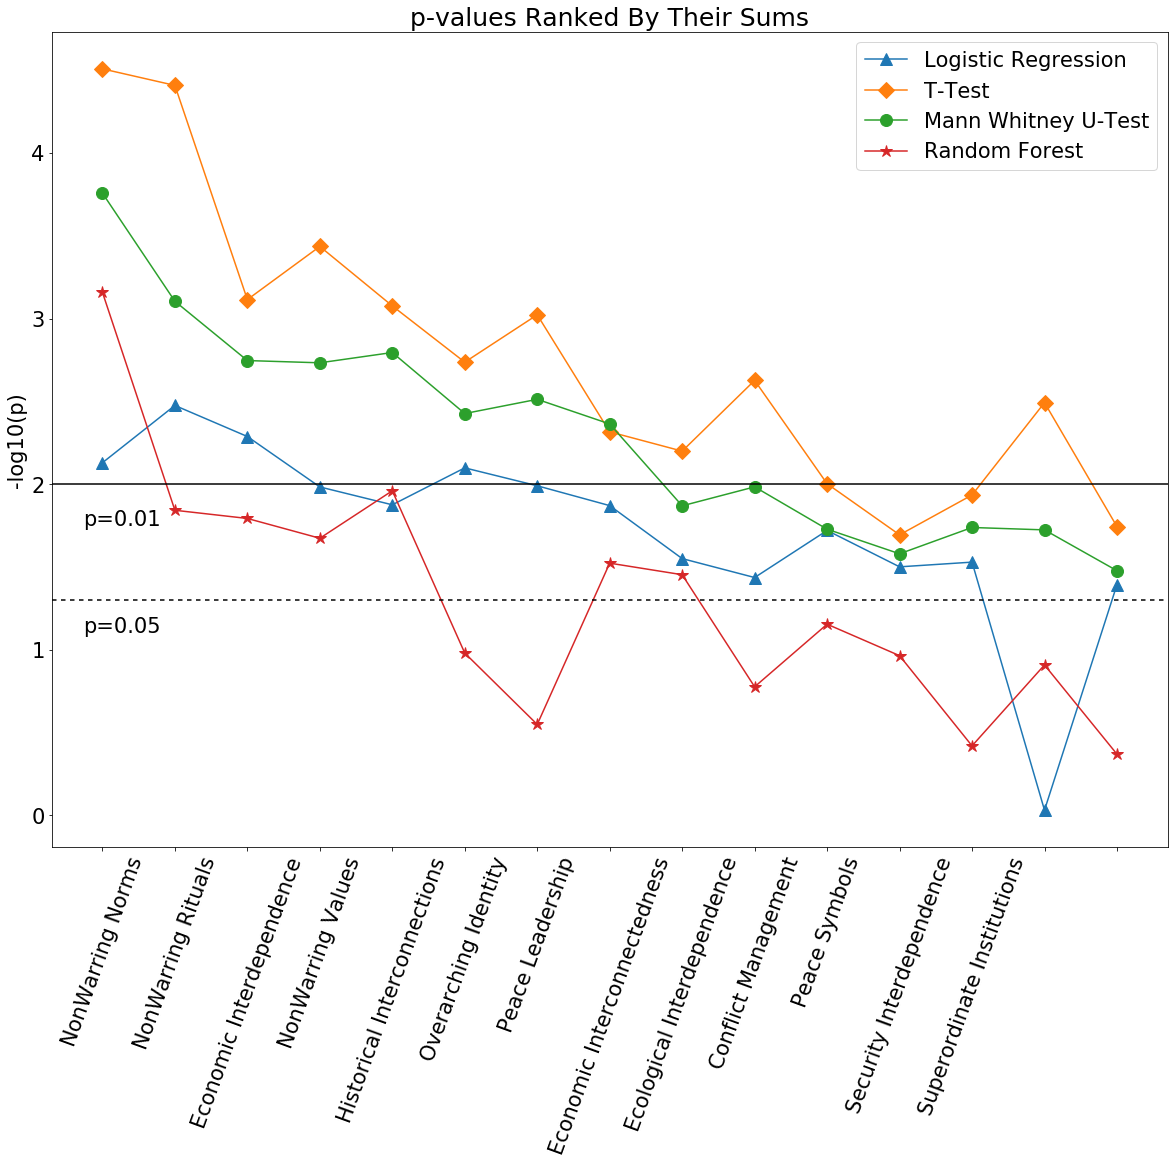

In [179]:
plt.figure()
plt.rcParams.update({'font.size': 20.95})
plt.subplots(figsize=(20,15))
plt.title('p-values Ranked By Their Sums')

for col in methods_srted_logsum[log_columns].columns:
        plt.plot(methods_srted_logsum[col], marker=next(marker), markersize=12)
    
plt.axhline(np.log10(1/0.01), 0, color='black', label='0.5')
plt.text(0.8, 1.75, "p=0.01", color='black', horizontalalignment='right')
plt.axhline(np.log10(1/0.05), 0, color='black', label='0.5', dashes=(3,3))
plt.text(0.8, 1.10, "p=0.05", color='black', horizontalalignment='right')

plt.xticks(range(X.shape[1]), VARS_DECODED, rotation=70)
# plt.locator_params(axis='x', nbins=20)
plt.ylabel('-log10(p)')
plt.legend(methods_names)

plt.savefig('sum.png', quality=95, bbox_inches="tight")
plt.show()

<Figure size 432x288 with 0 Axes>

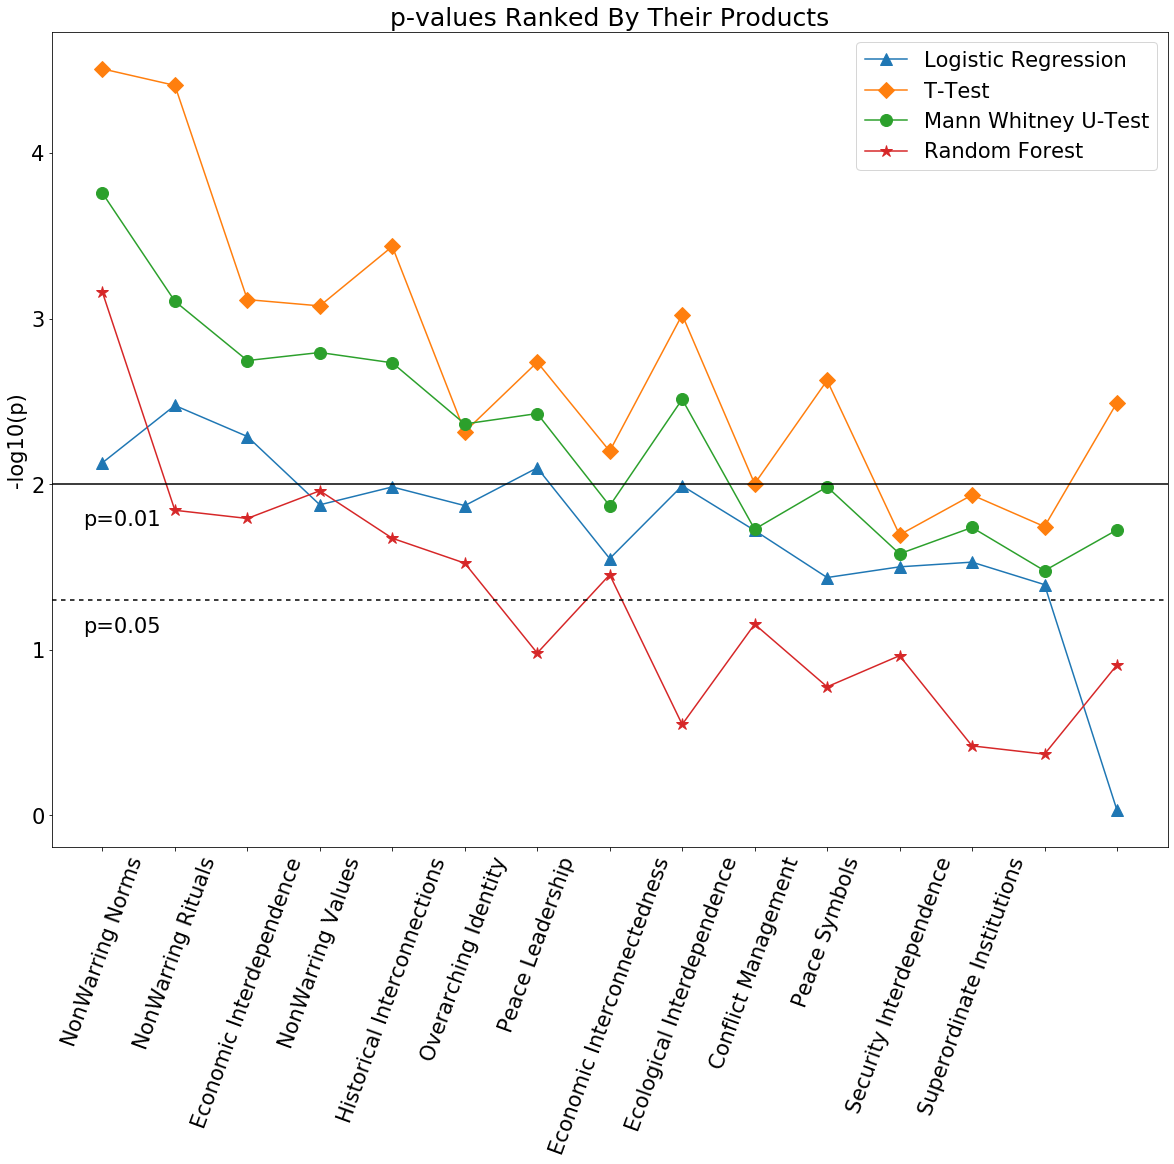

In [180]:
plt.figure()
plt.rcParams.update({'font.size': 20.95})
plt.subplots(figsize=(20,15))
plt.title('p-values Ranked By Their Products')

for col in methods_srted_logproduct[log_columns].columns:
        plt.plot(methods_srted_logproduct[col], marker=next(marker), markersize=12)
 
plt.axhline(np.log10(1/0.01), 0, color='black', label='0.5')
plt.text(0.8, 1.75, "p=0.01", color='black', horizontalalignment='right')
plt.axhline(np.log10(1/0.05), 0, color='black', label='0.5', dashes=(3,3))
plt.text(0.8, 1.10, "p=0.05", color='black', horizontalalignment='right')

plt.xticks(range(X.shape[1]), VARS_DECODED, rotation=70)
# plt.locator_params(axis='x', nbins=20)
plt.ylabel('-log10(p)')
plt.legend(methods_names)

plt.savefig('product.png', quality=95, bbox_inches="tight")
plt.show()